<a href="https://colab.research.google.com/github/sreeja-01p/DON_Concentration_Prediction/blob/main/DON_concentration_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DON Concentration Prediction in Corn Samples

####upload dataset

In [1]:
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['MLE-Assignment.csv']))

print("First 5 rows:")
print(df.head())
print("\nSummary:")
print(df.describe())

Saving MLE-Assignment.csv to MLE-Assignment.csv
First 5 rows:
           hsi_id         0         1         2         3         4         5  \
0  imagoai_corn_0  0.416181  0.396844  0.408985  0.372865  0.385293  0.365390   
1  imagoai_corn_1  0.415797  0.402956  0.402564  0.396014  0.397192  0.389634   
2  imagoai_corn_2  0.389023  0.371206  0.373098  0.373872  0.361056  0.349709   
3  imagoai_corn_3  0.468837  0.473255  0.462949  0.459335  0.461672  0.459824   
4  imagoai_corn_4  0.483352  0.487274  0.469153  0.487648  0.464026  0.451152   

          6         7         8  ...       439       440       441       442  \
0  0.355226  0.343350  0.344837  ...  0.710280  0.717482  0.715078  0.705379   
1  0.375671  0.363689  0.373883  ...  0.684011  0.697271  0.701995  0.696077   
2  0.333882  0.330841  0.328925  ...  0.683054  0.669286  0.663179  0.676165   
3  0.458194  0.427737  0.415360  ...  0.742782  0.730801  0.736787  0.730044   
4  0.458229  0.440782  0.426193  ...  0.770227  0.7

####preprocessing

Spectral columns: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155',

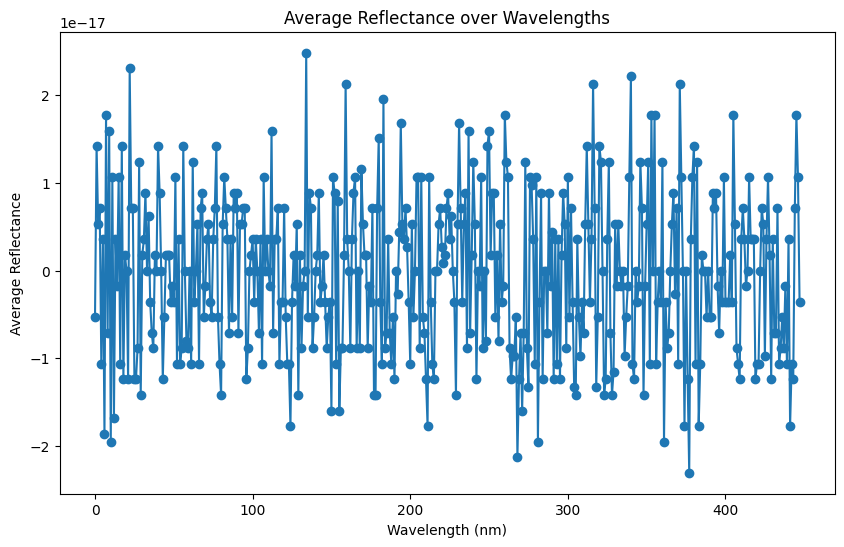

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
#from sklearn.decomposition import PCA

#list spectral columns except 'hsi_id' and 'vomitoxin_ppb'
wavelength_cols = [col for col in df.columns if col not in ['hsi_id', 'vomitoxin_ppb']]
print("Spectral columns:", wavelength_cols)

#convert spectral columns to numeric
df[wavelength_cols] = df[wavelength_cols].apply(pd.to_numeric, errors='coerce')

#plotting the average reflectance over wavelengths
avg_reflectance = df[wavelength_cols].mean()
#since column names are string representations of numbers, convert them to integers
wavelengths = [int(col) for col in wavelength_cols]
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, avg_reflectance, marker='o')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Average Reflectance')
plt.title('Average Reflectance over Wavelengths')
plt.show()

#handling missing values using mean imputation (only for numeric columns)
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

#standardizing spectral features with StandardScaler
scaler = StandardScaler()
df[wavelength_cols] = scaler.fit_transform(df[wavelength_cols])

#splitting the data into features (spectral data) and target (vomitoxin_ppb)
X = df[wavelength_cols]
y = df['vomitoxin_ppb']

#train test split(80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

####selecting model and training

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim

#defining regression neural network
class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.3)           #dropout for regularization
        self.fc3 = nn.Linear(64, 32)             #hidden layer
        self.fc4 = nn.Linear(32, 1)              #output layer 1 for regression
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

#convering training data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

#instantiating the model
input_dim = X_train.shape[1]
model = RegressionNN(input_dim)

#defining loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

#training loop with early stopping
num_epochs = 350
patience = 25
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    #evaluate on test set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break

#load the best model state.
model.load_state_dict(best_model_state)

Epoch 1/350 - Train Loss: 153729152.0000 - Val Loss: 299005088.0000
Epoch 2/350 - Train Loss: 153727792.0000 - Val Loss: 299001856.0000
Epoch 3/350 - Train Loss: 153725616.0000 - Val Loss: 298996960.0000
Epoch 4/350 - Train Loss: 153723168.0000 - Val Loss: 298989952.0000
Epoch 5/350 - Train Loss: 153718368.0000 - Val Loss: 298980288.0000
Epoch 6/350 - Train Loss: 153712000.0000 - Val Loss: 298967520.0000
Epoch 7/350 - Train Loss: 153705136.0000 - Val Loss: 298950816.0000
Epoch 8/350 - Train Loss: 153698240.0000 - Val Loss: 298929248.0000
Epoch 9/350 - Train Loss: 153683696.0000 - Val Loss: 298901696.0000
Epoch 10/350 - Train Loss: 153667456.0000 - Val Loss: 298867104.0000
Epoch 11/350 - Train Loss: 153648064.0000 - Val Loss: 298823584.0000
Epoch 12/350 - Train Loss: 153619936.0000 - Val Loss: 298768992.0000
Epoch 13/350 - Train Loss: 153586736.0000 - Val Loss: 298701792.0000
Epoch 14/350 - Train Loss: 153556384.0000 - Val Loss: 298619616.0000
Epoch 15/350 - Train Loss: 153506944.0000 -

<All keys matched successfully>

#### model evaluation

Baseline Metrics (Predicting the Mean):
Baseline MAE: 6432.880
Baseline RMSE: 16719.244
Baseline R²: 0.000
Baseline Median Absolute Error: 4058.000

Model Metrics:
Model MAE: 3815.786
Model RMSE: 10459.727
Model R²: 0.609
Model Median Absolute Error: 654.880


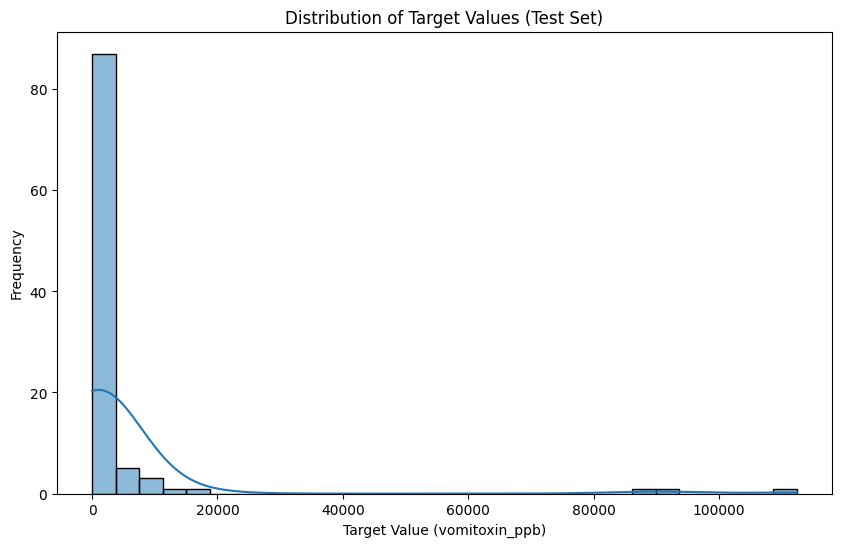

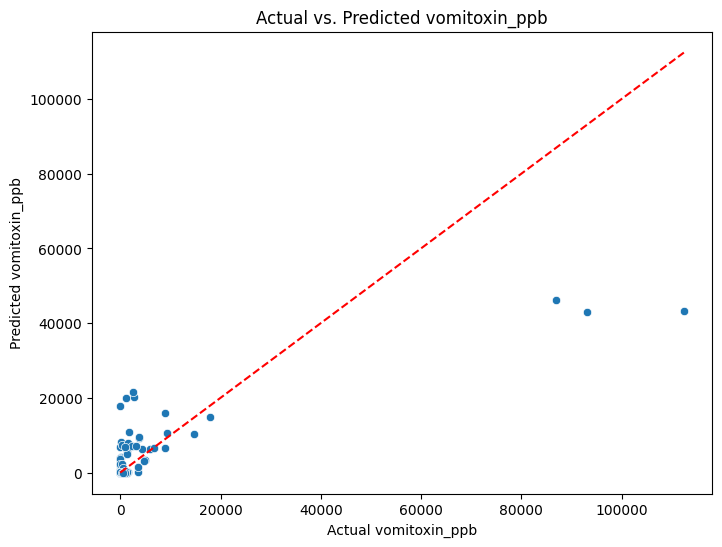

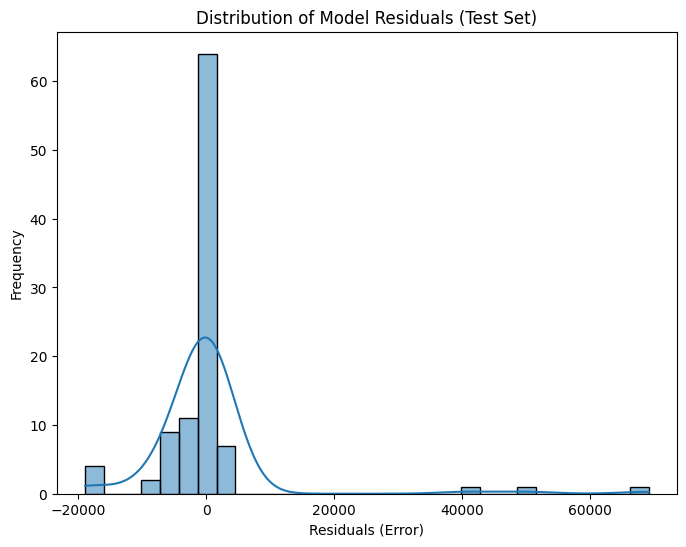

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import torch

#generate Model Predictions
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy().flatten()

#baseline comparison
#for the test set, predict the mean of y_test for every instance
baseline_value = y_test.mean()
baseline_predictions = np.full(shape=y_test.shape, fill_value=baseline_value)

#calculate baseline metrics
baseline_mae = mean_absolute_error(y_test, baseline_predictions)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
baseline_r2 = r2_score(y_test, baseline_predictions)
baseline_median = median_absolute_error(y_test, baseline_predictions)

print("Baseline Metrics (Predicting the Mean):")
print(f"Baseline MAE: {baseline_mae:.3f}")
print(f"Baseline RMSE: {baseline_rmse:.3f}")
print(f"Baseline R²: {baseline_r2:.3f}")
print(f"Baseline Median Absolute Error: {baseline_median:.3f}")

#model metrics using model predictions
#'predictions' should be the output from the trained model on the test set
model_mae = mean_absolute_error(y_test, predictions)
model_rmse = np.sqrt(mean_squared_error(y_test, predictions))
model_r2 = r2_score(y_test, predictions)
model_median = median_absolute_error(y_test, predictions)

print("\nModel Metrics:")
print(f"Model MAE: {model_mae:.3f}")
print(f"Model RMSE: {model_rmse:.3f}")
print(f"Model R²: {model_r2:.3f}")
print(f"Model Median Absolute Error: {model_median:.3f}")

#visualizations
#distribution of target values
plt.figure(figsize=(10,6))
sns.histplot(y_test, bins=30, kde=True)
plt.xlabel("Target Value (vomitoxin_ppb)")
plt.ylabel("Frequency")
plt.title("Distribution of Target Values (Test Set)")
plt.show()

#plot actual vs predicted values
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=predictions)
plt.xlabel("Actual vomitoxin_ppb")
plt.ylabel("Predicted vomitoxin_ppb")
plt.title("Actual vs. Predicted vomitoxin_ppb")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  #45 deg line
plt.show()

#plot residuals
residuals = y_test - predictions
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals (Error)")
plt.ylabel("Frequency")
plt.title("Distribution of Model Residuals (Test Set)")
plt.show()

####Interpretability using SHAP

In [86]:
!pip install shap
import shap
import torch
import numpy as np

def model_predict(data_numpy):
    #data_numpy is 2D NumPy array (batch_size, n_features)
    #returns 1D NumPy array of predictions

    #convert to PyTorch tensor
    data_torch = torch.tensor(data_numpy, dtype=torch.float32)

    #get predictions from the model in eval mode, no grad
    model.eval()
    with torch.no_grad():
        preds = model(data_torch).numpy().flatten()
    return preds

#first 100 samples from X_train_tensor as background
background = X_train_tensor[:100].numpy()

explainer = shap.KernelExplainer(model_predict, background)

  0%|          | 0/50 [00:00<?, ?it/s]

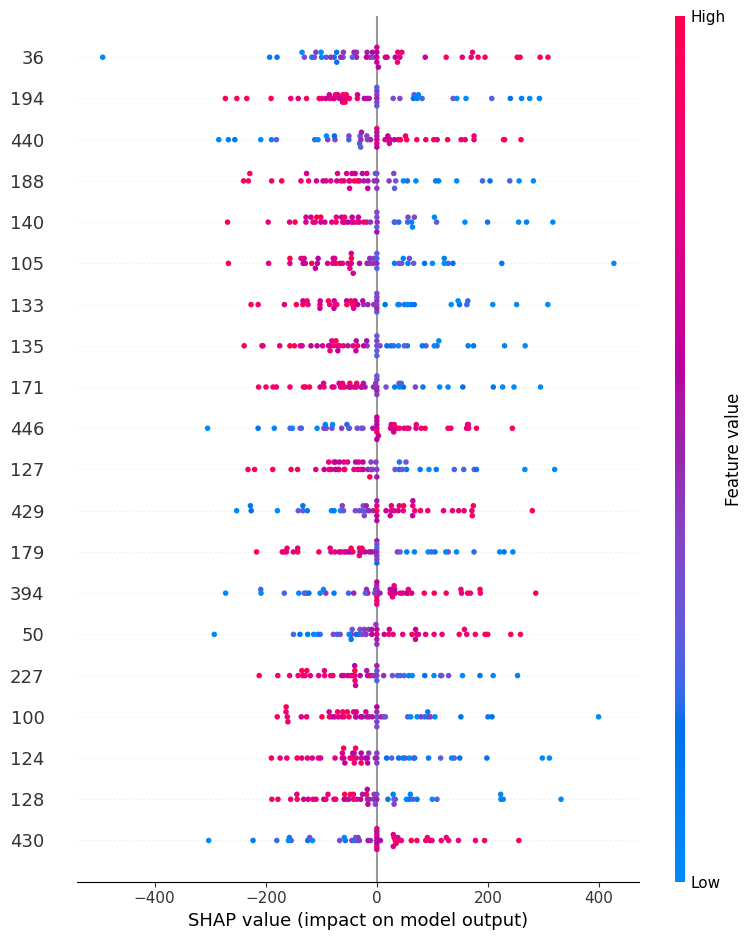

In [87]:
#explain the first 50 test samples
X_test_subset = X_test_tensor[:50].numpy()

shap_values = explainer.shap_values(X_test_subset)

shap.summary_plot(shap_values, X_test_subset, feature_names=wavelength_cols)

####saving model and scaler for deployment

In [88]:
import pickle

#save the trained model
torch.save(model.state_dict(), 'model.pth')

#save the scaler so that new data can be preprocessed in the same way
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [89]:
from google.colab import files

files.download('model.pth')
files.download('scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>